In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Extract Files

In [ ]:
savepath =  "/content/drive/MyDrive/2022_NLP/Image_Captioning/"

In [ ]:
import os 
import zipfile

for item in os.listdir(savepath):
  if "zip" in item:
    zip = zipfile.ZipFile(savepath + item)
    zip.extractall()
    zip.close()

# Extract Images' Features and Turn Description into Dictionary

Image's name : Feature (1, 4096)

4096 => the last fully conncted layer in VGG16, if not including the top layer, has 4096 neuron. 

In [ ]:
from os import listdir
from os import path
from pickle import dump
from keras.applications.vgg16 import VGG16
from keras_preprocessing.image import load_img
from keras_preprocessing.image import img_to_array
from keras.applications.vgg16 import preprocess_input
from keras.models import Model

# extract features from each photo in the directory
def extract_features(directory):
	# load the model
	model = VGG16()
	# re-structure the model
	model.layers.pop()
	model = Model(inputs=model.inputs, outputs=model.layers[-2].output)
	# summarize
	model.summary()
	# extract features from each photo
	features = dict()
	for name in listdir(directory):
		# load an image from file
		filename = path.join(directory, name)
		image = load_img(filename, target_size=(224, 224))
		# convert the image pixels to a numpy array
		image = img_to_array(image)
		# reshape data for the model
		image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
		# prepare the image for the VGG model
		image = preprocess_input(image)
		# get features
		feature = model.predict(image, verbose=0)
		# get image id
		image_id = name.split('.')[0]
		# store feature
		features[image_id] = feature
		print('>%s' % name)
	return features

# extract features from all images
directory = '/content/Flicker8k_Dataset'
print(directory)
features = extract_features(directory)
print('Extracted Features: %d' % len(features))
# save to file
dump(features, open('features.pkl', 'wb'))

Image's name : Description

In [ ]:
import string
import re

# load doc into memory
def load_doc(filename):
	# open the file as read only
	file = open(filename, 'r')
	# read all text
	text = file.read()
	# close the file
	file.close()
	return text

# extract descriptions for images
def load_descriptions(doc):
	mapping = dict()
	# process lines
	for line in doc.split('\n'):
		# split line by white space
		tokens = line.split()
		if len(line) < 2:
			continue
		# take the first token as the image id, the rest as the description
		image_id, image_desc = tokens[0], tokens[1:]
		# remove filename from image id
		image_id = image_id.split('.')[0]
		# convert description tokens back to string
		image_desc = ' '.join(image_desc)
		# create the list if needed
		if image_id not in mapping:
			mapping[image_id] = list()
		# store description
		mapping[image_id].append(image_desc)
	return mapping

def clean_descriptions(descriptions):
	# prepare regex for char filtering
	re_punc = re.compile('[%s]' % re.escape(string.punctuation))
	for _, desc_list in descriptions.items():
		for i in range(len(desc_list)):
			desc = desc_list[i]
			# tokenize
			desc = desc.split()
			# convert to lower case
			desc = [word.lower() for word in desc]
			# remove punctuation from each token
			desc = [re_punc.sub('', w) for w in desc]
			# remove hanging 's' and 'a'
			desc = [word for word in desc if len(word)>1]
			# remove tokens with numbers in them
			desc = [word for word in desc if word.isalpha()]
			# store as string
			desc_list[i] =  ' '.join(desc)

# convert the loaded descriptions into a vocabulary of words
def to_vocabulary(descriptions):
	# build a list of all description strings
	all_desc = set()
	for key in descriptions.keys():
		[all_desc.update(d.split()) for d in descriptions[key]]
	return all_desc

# save descriptions to file, one per line
def save_descriptions(descriptions, filename):
	lines = list()
	for key, desc_list in descriptions.items():
		for desc in desc_list:
			lines.append(key + ' ' + desc)
	data = '\n'.join(lines)
	file = open(filename, 'w')
	file.write(data)
	file.close()

filename = '/content/Flickr8k.token.txt'
# load descriptions
doc = load_doc(filename)
# parse descriptions
descriptions = load_descriptions(doc)
print('Loaded: %d ' % len(descriptions))
# clean descriptions
clean_descriptions(descriptions)
# summarize vocabulary
vocabulary = to_vocabulary(descriptions)
print('Vocabulary Size: %d' % len(vocabulary))
# save to file
save_descriptions(descriptions, 'descriptions.txt')

Loaded: 8092 
Vocabulary Size: 8763


File loading

will be executed in the next cell

In [ ]:
# from pickle import load

# # load doc into memory
# def load_doc(filename):
# 	# open the file as read only
# 	file = open(filename, 'r')
# 	# read all text
# 	text = file.read()
# 	# close the file
# 	file.close()
# 	return text

# # load a pre-defined list of photo identifiers
# def load_set(filename):
# 	doc = load_doc(filename)
# 	dataset = list()
# 	# process line by line
# 	for line in doc.split('\n'):
# 		# skip empty lines
# 		if len(line) < 1:
# 			continue
# 		# get the image identifier
# 		identifier = line.split('.')[0]
# 		dataset.append(identifier)
# 	return set(dataset)

# # load clean descriptions into memory
# def load_clean_descriptions(filename, dataset):
# 	# load document
# 	doc = load_doc(filename)
# 	descriptions = dict()
# 	for line in doc.split('\n'):
# 		# split line by white space
# 		tokens = line.split()
# 		# split id from description
# 		image_id, image_desc = tokens[0], tokens[1:]
# 		# skip images not in the set
# 		if image_id in dataset:
# 			# create list
# 			if image_id not in descriptions:
# 				descriptions[image_id] = list()
# 			# wrap description in tokens
# 			desc = 'startseq ' + ' '.join(image_desc) + ' endseq'
# 			# store
# 			descriptions[image_id].append(desc)
# 	return descriptions

# # load photo features
# def load_photo_features(filename, dataset):
# 	# load all features
# 	all_features = load(open(filename, 'rb'))
# 	# filter features
# 	features = {k: all_features[k] for k in dataset}
# 	return features

# # load training dataset (6K)
# filename = '/content/Flickr_8k.trainImages.txt'
# train = load_set(filename)
# print('Dataset: %d' % len(train))
# # descriptions
# train_descriptions = load_clean_descriptions('/content/drive/MyDrive/2022_NLP/Image_Captioning/descriptions.txt', train)
# print('Descriptions: train=%d' % len(train_descriptions))
# # photo features
# train_features = load_photo_features('/content/drive/MyDrive/2022_NLP/Image_Captioning/features.pkl', train)
# print('Photos: train=%d' % len(train_features))

Dataset: 6000
Descriptions: train=6000
Photos: train=6000


# Training Input Preparation

Load images' features and description and turn them into sequences as inputs

Sequences will be divided into train data and validation data according to the inclusions of the two files: "..trainImages.txt" and "..devImages.txt". 

For the description sequences, a sequence starts with "startseq" and ends with "endseq".

In [ ]:
from numpy import array
from pickle import load
from keras_preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

# load doc into memory
def load_doc(filename):
	# open the file as read only
	file = open(filename, 'r')
	# read all text
	text = file.read()
	# close the file
	file.close()
	return text

# load a pre-defined list of photo identifiers
def load_set(filename):
	doc = load_doc(filename)
	dataset = list()
	# process line by line
	for line in doc.split('\n'):
		# skip empty lines
		if len(line) < 1:
			continue
		# get the image identifier
		identifier = line.split('.')[0]
		dataset.append(identifier)
	return set(dataset)

# load clean descriptions into memory
def load_clean_descriptions(filename, dataset):
	# load document
	doc = load_doc(filename)
	descriptions = dict()
	for line in doc.split('\n'):
		# split line by white space
		tokens = line.split()
		# split id from description
		image_id, image_desc = tokens[0], tokens[1:]
		# skip images not in the set
		if image_id in dataset:
			# create list
			if image_id not in descriptions:
				descriptions[image_id] = list()
			# wrap description in tokens
			desc = 'startseq ' + ' '.join(image_desc) + ' endseq'
			# store
			descriptions[image_id].append(desc)
	return descriptions

# load photo features
def load_photo_features(filename, dataset):
	# load all features
	all_features = load(open(filename, 'rb'))
	# filter features
	features = {k: all_features[k] for k in dataset}
	return features

# covert a dictionary of clean descriptions to a list of descriptions
def to_lines(descriptions):
	all_desc = list()
	for key in descriptions.keys():
		[all_desc.append(d) for d in descriptions[key]]
	return all_desc

# fit a tokenizer given caption descriptions
def create_tokenizer(descriptions):
	lines = to_lines(descriptions)
	tokenizer = Tokenizer()
	tokenizer.fit_on_texts(lines)
	return tokenizer

# calculate the length of the description with the most words
def max_length(descriptions):
	lines = to_lines(descriptions)
	return max(len(d.split()) for d in lines)

# create sequences of images, input sequences and output words for an image
def create_sequences(tokenizer, max_length, descriptions, photos):
	X1, X2, y = list(), list(), list()
	# walk through each image identifier
	for key, desc_list in descriptions.items():
		# walk through each description for the image
		for desc in desc_list:
			# encode the sequence
			seq = tokenizer.texts_to_sequences([desc])[0]
			# split one sequence into multiple X,y pairs
			for i in range(1, len(seq)):
				# split into input and output pair
				in_seq, out_seq = seq[:i], seq[i]
				# pad input sequence
				in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
				# encode output sequence
				out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
				# store
				X1.append(photos[key][0])
				X2.append(in_seq)
				y.append(out_seq)
	return array(X1), array(X2), array(y)

# load training dataset (6K)
filename = '/content/Flickr_8k.trainImages.txt'
train = list(load_set(filename))[:1800]
train = set(train)
print('Dataset: %d' % len(train))
# descriptions
train_descriptions = load_clean_descriptions('/content/drive/MyDrive/2022_NLP/Image_Captioning/descriptions.txt', train)
print('Descriptions: train=%d' % len(train_descriptions))
# photo features
train_features = load_photo_features('/content/drive/MyDrive/2022_NLP/Image_Captioning/features.pkl', train)
print('Photos: train=%d' % len(train_features))
# prepare tokenizer
tokenizer = create_tokenizer(train_descriptions)
dump(tokenizer, open(savepath + 'tokenizer.pkl', 'wb'))

vocab_size = len(tokenizer.word_index) + 1
print('Vocabulary Size: %d' % vocab_size)
# determine the maximum sequence length
max_length = max_length(train_descriptions)
print('Description Length: %d' % max_length)
# prepare sequences
# X1train, X2train, ytrain = create_sequences(tokenizer, max_length, train_descriptions, train_features)

# load test set
filename = '/content/Flickr_8k.devImages.txt'
test = list(load_set(filename))[:300]
test = set(test)
print('Dataset: %d' % len(test))
# descriptions
test_descriptions = load_clean_descriptions('/content/drive/MyDrive/2022_NLP/Image_Captioning/descriptions.txt', test)
print('Descriptions: test=%d' % len(test_descriptions))
# photo features
test_features = load_photo_features('/content/drive/MyDrive/2022_NLP/Image_Captioning/features.pkl', test)
print('Photos: test=%d' % len(test_features))
# prepare sequences
# X1test, X2test, ytest = create_sequences(tokenizer, max_length, test_descriptions, test_features)

Dataset: 1800
Descriptions: train=1800
Photos: train=1800
Vocabulary Size: 4292
Description Length: 34
Dataset: 300
Descriptions: test=300
Photos: test=300


# Model Training: Encoder and Decoder

Images' feature and description sequences will be fed in the model as the inputs.

In [ ]:
from tensorflow.keras.utils import plot_model
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Embedding
from keras.layers import Dropout
from tensorflow.keras.layers import Add
from keras.callbacks import ModelCheckpoint

# define the captioning model
def define_model(vocab_size, max_length):
	# feature extractor model
	inputs1 = Input(shape=(4096,))
	fe1 = Dropout(0.5)(inputs1)
	fe2 = Dense(256, activation='relu')(fe1)
	# sequence model
	inputs2 = Input(shape=(max_length,))
	se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
	se2 = Dropout(0.5)(se1)
	se3 = LSTM(256)(se2)
	# decoder model
	decoder1 = Add()([fe2, se3])
	decoder2 = Dense(256, activation='relu')(decoder1)
	outputs = Dense(vocab_size, activation='softmax')(decoder2)
	# tie it together [image, seq] [word]
	model = Model(inputs=[inputs1, inputs2], outputs=outputs)
	# compile model
	model.compile(loss='categorical_crossentropy', optimizer='adam')
	# summarize model
	model.summary()
	plot_model(model, to_file = 'model.png', show_shapes=True)
	return model

# define the model
model = define_model(vocab_size, max_length)
# define checkpoint callback
checkpoint = ModelCheckpoint('/content/drive/MyDrive/2022_NLP/Image_Captioning/model.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='min')
# fit model
model.fit([X1train, X2train], ytrain, epochs=20, verbose=2, callbacks=[checkpoint], validation_data=([X1test, X2test], ytest))

# Model Testing with Data Generation

The function *generate_desc* serves as the decoder, iteratively bringing "startseq" combined with output sequences back to the model as input sequences. 

Finally, the model will be evaluated with the BLEU score.

In [ ]:
from numpy import argmax
from pickle import load
from keras_preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from keras.models import load_model
from nltk.translate.bleu_score import corpus_bleu

# load doc into memory
def load_doc(filename):
	# open the file as read only
	file = open(filename, 'r')
	# read all text
	text = file.read()
	# close the file
	file.close()
	return text

# load a pre-defined list of photo identifiers
def load_set(filename):
	doc = load_doc(filename)
	dataset = list()
	# process line by line
	for line in doc.split('\n'):
		# skip empty lines
		if len(line) < 1:
			continue
		# get the image identifier
		identifier = line.split('.')[0]
		dataset.append(identifier)
	return set(dataset)

# load clean descriptions into memory
def load_clean_descriptions(filename, dataset):
	# load document
	doc = load_doc(filename)
	descriptions = dict()
	for line in doc.split('\n'):
		# split line by white space
		tokens = line.split()
		# split id from description
		image_id, image_desc = tokens[0], tokens[1:]
		# skip images not in the set
		if image_id in dataset:
			# create list
			if image_id not in descriptions:
				descriptions[image_id] = list()
			# wrap description in tokens
			desc = 'startseq ' + ' '.join(image_desc) + ' endseq'
			# store
			descriptions[image_id].append(desc)
	return descriptions

# load photo features
def load_photo_features(filename, dataset):
	# load all features
	all_features = load(open(filename, 'rb'))
	# filter features
	features = {k: all_features[k] for k in dataset}
	return features

# covert a dictionary of clean descriptions to a list of descriptions
def to_lines(descriptions):
	all_desc = list()
	for key in descriptions.keys():
		[all_desc.append(d) for d in descriptions[key]]
	return all_desc

# fit a tokenizer given caption descriptions
def create_tokenizer(descriptions):
	lines = to_lines(descriptions)
	tokenizer = Tokenizer()
	tokenizer.fit_on_texts(lines)
	return tokenizer

# calculate the length of the description with the most words
def max_length(descriptions):
	lines = to_lines(descriptions)
	return max(len(d.split()) for d in lines)

# map an integer to a word
def word_for_id(integer, tokenizer):
	for word, index in tokenizer.word_index.items():
		if index == integer:
			return word
	return None

# generate a description for an image
def generate_desc(model, tokenizer, photo, max_length):
	# seed the generation process
	in_text = 'startseq'
	# iterate over the whole length of the sequence
	for _ in range(max_length):
		# integer encode input sequence
		sequence = tokenizer.texts_to_sequences([in_text])[0]
		# pad input
		sequence = pad_sequences([sequence], maxlen=max_length)
		# predict next word
		yhat = model.predict([photo,sequence], verbose=0)
		# convert probability to integer
		yhat = argmax(yhat)
		# map integer to word
		word = word_for_id(yhat, tokenizer)
		# stop if we cannot map the word
		if word is None:
			break
		# append as input for generating the next word
		in_text += ' ' + word
		# stop if we predict the end of the sequence
		if word == 'endseq':
			break
	return in_text

# remove start/end sequence tokens from a summary
def cleanup_summary(summary):
	# remove start of sequence token
	index = summary.find('startseq ')
	if index > -1:
		summary = summary[len('startseq '):]
	# remove end of sequence token
	index = summary.find(' endseq')
	if index > -1:
		summary = summary[:index]
	return summary

# evaluate the skill of the model
def evaluate_model(model, descriptions, photos, tokenizer, max_length):
	actual, predicted = list(), list()
	# step over the whole set
	for key, desc_list in descriptions.items():
		# generate description
		yhat = generate_desc(model, tokenizer, photos[key], max_length)
		# clean up prediction
		yhat = cleanup_summary(yhat)
		# store actual and predicted
		references = [cleanup_summary(d).split() for d in desc_list]
		actual.append(references)
		predicted.append(yhat.split())
	# calculate BLEU score
	print('BLEU-1: %f' % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
	print('BLEU-2: %f' % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))
	print('BLEU-3: %f' % corpus_bleu(actual, predicted, weights=(0.3, 0.3, 0.3, 0)))
	print('BLEU-4: %f' % corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25)))

# load training dataset (6K)
filename = '/content/Flickr_8k.trainImages.txt'
train = list(load_set(filename))[:600]
train = set(train)
print('Dataset: %d' % len(train))
# descriptions
train_descriptions = load_clean_descriptions(savepath + 'descriptions.txt', train)
print('Descriptions: train=%d' % len(train_descriptions))
# prepare tokenizer
tokenizer = create_tokenizer(train_descriptions)
vocab_size = len(tokenizer.word_index) + 1
print('Vocabulary Size: %d' % vocab_size)
# determine the maximum sequence length
# max_length = max_length(train_descriptions)
max_length = 34
print('Description Length: %d' % max_length)

# load test set
filename = '/content/Flickr_8k.trainImages.txt'
test = list(load_set(filename))[:100]
test = set(test)
print('Dataset: %d' % len(test))
# descriptions
test_descriptions = load_clean_descriptions(savepath + 'descriptions.txt', test)
print('Descriptions: test=%d' % len(test_descriptions))
# photo features
test_features = load_photo_features(savepath + 'features.pkl', test)
print('Photos: test=%d' % len(test_features))

Dataset: 600
Descriptions: train=600
Vocabulary Size: 2409
Description Length: 34
Dataset: 100
Descriptions: test=100
Photos: test=100


In [ ]:
# load the model
filename = savepath + 'model.h5'
model = load_model(filename)
# evaluate model
evaluate_model(model, test_descriptions, test_features, tokenizer, max_length)

BLEU-1: 0.364720
BLEU-2: 0.138736
BLEU-3: 0.000000
BLEU-4: 0.000000


/usr/local/lib/python3.8/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.8/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


The result seems a bit unwelcomed, but it is pretty good given the limited resources.

In [ ]:
# from keras_preprocessing.text import Tokenizer
# from pickle import dump

# # load doc into memory
# def load_doc(filename):
# 	# open the file as read only
# 	file = open(filename, 'r')
# 	# read all text
# 	text = file.read()
# 	# close the file
# 	file.close()
# 	return text

# # load a pre-defined list of photo identifiers
# def load_set(filename):
# 	doc = load_doc(filename)
# 	dataset = list()
# 	# process line by line
# 	for line in doc.split('\n'):
# 		# skip empty lines
# 		if len(line) < 1:
# 			continue
# 		# get the image identifier
# 		identifier = line.split('.')[0]
# 		dataset.append(identifier)
# 	return set(dataset)

# # load clean descriptions into memory
# def load_clean_descriptions(filename, dataset):
# 	# load document
# 	doc = load_doc(filename)
# 	descriptions = dict()
# 	for line in doc.split('\n'):
# 		# split line by white space
# 		tokens = line.split()
# 		# split id from description
# 		image_id, image_desc = tokens[0], tokens[1:]
# 		# skip images not in the set
# 		if image_id in dataset:
# 			# create list
# 			if image_id not in descriptions:
# 				descriptions[image_id] = list()
# 			# wrap description in tokens
# 			desc = 'startseq ' + ' '.join(image_desc) + ' endseq'
# 			# store
# 			descriptions[image_id].append(desc)
# 	return descriptions

# # covert a dictionary of clean descriptions to a list of descriptions
# def to_lines(descriptions):
# 	all_desc = list()
# 	for key in descriptions.keys():
# 		[all_desc.append(d) for d in descriptions[key]]
# 	return all_desc

# # fit a tokenizer given caption descriptions
# def create_tokenizer(descriptions):
# 	lines = to_lines(descriptions)
# 	tokenizer = Tokenizer()
# 	tokenizer.fit_on_texts(lines)
# 	return tokenizer

# # load training dataset
# filename = '/content//Flickr_8k.trainImages.txt'
# train = load_set(filename)
# print('Dataset: %d' % len(train))
# # descriptions
# train_descriptions = load_clean_descriptions(savepath + 'descriptions.txt', train)
# print('Descriptions: train=%d' % len(train_descriptions))
# # prepare tokenizer
# tokenizer = create_tokenizer(train_descriptions)
# # save the tokenizer


Dataset: 6000
Descriptions: train=6000


Now, let's experiment with some images.

In [ ]:
from pickle import load
from numpy import argmax
from keras_preprocessing.sequence import pad_sequences
from keras.applications.vgg16 import VGG16
from keras_preprocessing.image import load_img
from keras_preprocessing.image import img_to_array
from keras.applications.vgg16 import preprocess_input
from keras.models import Model
from keras.models import load_model

# extract features from each photo in the directory
def extract_features(filename):
	# load the model
	model = VGG16()
	# re-structure the model
	model.layers.pop()
	model = Model(inputs=model.inputs, outputs=model.layers[-2].output)
	# load the photo
	image = load_img(filename, target_size=(224, 224))
	# convert the image pixels to a numpy array
	image = img_to_array(image)
	# reshape data for the model
	image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
	# prepare the image for the VGG model
	image = preprocess_input(image)
	# get features
	feature = model.predict(image, verbose=0)
	return feature

# map an integer to a word
def word_for_id(integer, tokenizer):
	for word, index in tokenizer.word_index.items():
		if index == integer:
			return word
	return None

# remove start/end sequence tokens from a summary
def cleanup_summary(summary):
	# remove start of sequence token
	index = summary.find('startseq ')
	if index > -1:
		summary = summary[len('startseq '):]
	# remove end of sequence token
	index = summary.find(' endseq')
	if index > -1:
		summary = summary[:index]
	return summary

# generate a description for an image
def generate_desc(model, tokenizer, photo, max_length):
	# seed the generation process
	in_text = 'startseq'
	# iterate over the whole length of the sequence
	for _ in range(max_length):
		# integer encode input sequence
		sequence = tokenizer.texts_to_sequences([in_text])[0]
		# pad input
		sequence = pad_sequences([sequence], maxlen=max_length)
		# predict next word
		yhat = model.predict([photo,sequence], verbose=0)
		# convert probability to integer
		yhat = argmax(yhat)
		# map integer to word
		word = word_for_id(yhat, tokenizer)
		# stop if we cannot map the word
		if word is None:
			break
		# append as input for generating the next word
		in_text += ' ' + word
		# stop if we predict the end of the sequence
		if word == 'endseq':
			break
	return in_text

# load the tokenizer
tokenizer = load(open(savepath + 'tokenizer.pkl', 'rb'))
# pre-define the max sequence length (from training)
max_length = 34
# load the model
model = load_model(savepath + 'model.h5')
#model.summary()

(1, 4096)


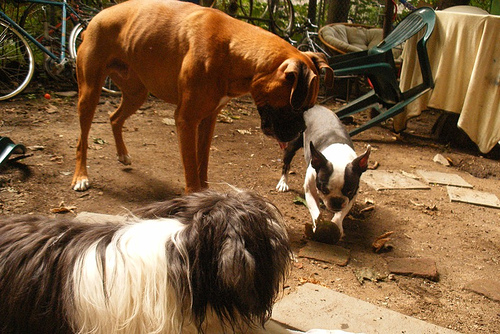

In [ ]:
# load and prepare the photograph
pic_path = "/content/Flicker8k_Dataset/1082252566_8c79beef93.jpg"

photo = extract_features(pic_path)
print(photo.shape)

image = load_img(pic_path)
display(image)


In [ ]:
# generate description

description = generate_desc(model, tokenizer, photo, max_length)
print(description)
description = cleanup_summary(description)
print(description)

startseq dog is running through the grass endseq
dog is running through the grass


Probably unreasonable, but this is a good start for Encoder-Decoder in Image Captioning.